<a href="https://colab.research.google.com/github/raveesharanamukage/Basic-Deep-Learning-Projects/blob/main/Forecast%20Revenue%20By%20MealPeriod/Corrected_XGBoost_BreakFast_RC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
About the Project
+ This project is a hotel revenue forecasting using ML with giving valuable insights to the client.
+ This hote has 9 Revenue Centres and 3 Mealperiods
+ First Task is to Forecast Revenue for 3 months for each Hotel Per MealPeriod




### Import Dataset & Librararies

In [ ]:
#Import necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#column_names=['Date','MealPeriod','RevenueCentreName','CheckTotal']
dataset=pd.read_csv('/content/drive/MyDrive/Datasets/hotel/Datasets/BreakFast_RevenueCenter_2.csv',parse_dates=['Date'])
print(dataset.head())
print(dataset.info()) #Consice summary of the DataFrame
print(dataset.describe())

        Date MealPeriod RevenueCentreName  CheckTotal
0 2023-01-01  BreakFast   RevenueCenter_2        35.0
1 2023-01-02  BreakFast   RevenueCenter_2       608.5
2 2023-01-03  BreakFast   RevenueCenter_2       234.0
3 2023-01-04  BreakFast   RevenueCenter_2        72.0
4 2023-01-05  BreakFast   RevenueCenter_2       704.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               486 non-null    datetime64[ns]
 1   MealPeriod         486 non-null    object        
 2   RevenueCentreName  486 non-null    object        
 3   CheckTotal         486 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 15.3+ KB
None
                                Date   CheckTotal
count                            486   486.000000
mean   2023-08-31 11:59:59.999999744   363.653807
min            

In [ ]:

dates=pd.date_range(start='2023-01-01',end='2024-04-30',freq='D')
data=dataset.copy()
#Generate full date range
dates = pd.date_range(start='2023-01-01', end='2024-04-30', freq='D')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

#Reindex with the full date range
df = data.reindex(dates)

#Rename index to 'Date' to make it clear
df.index.name = 'Date'

#Linear interpolation
df['CheckTotal'] = df['CheckTotal'].interpolate()

df = df.reset_index()
df.head()


,Date,MealPeriod,RevenueCentreName,CheckTotal
0,2023-01-01,BreakFast,RevenueCenter_2,35.0
1,2023-01-02,BreakFast,RevenueCenter_2,608.5
2,2023-01-03,BreakFast,RevenueCenter_2,234.0
3,2023-01-04,BreakFast,RevenueCenter_2,72.0
4,2023-01-05,BreakFast,RevenueCenter_2,704.0


In [ ]:
#Single row of Dataset
df.index.dtype
stamp = df.index[5]
df.loc[stamp]

,5
Date,2023-01-06 00:00:00
MealPeriod,BreakFast
RevenueCentreName,RevenueCenter_2
CheckTotal,97.0


### EDA

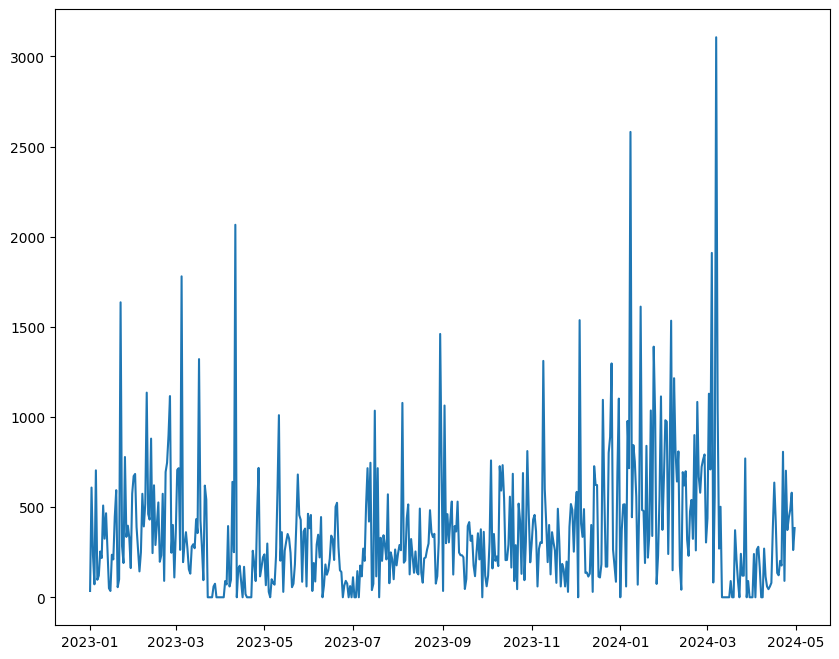

In [ ]:
#Visualize the revenue without considering meal period,revenue centre
plt.figure(figsize=(10,8))
plt.plot(df['Date'],df['CheckTotal'])
plt.show()

In [ ]:
df_break1=pd.DataFrame(dates,columns=['Date'])
df_break1['CheckTotal']=df['CheckTotal']
df_break1

,Date,CheckTotal
0,2023-01-01,35.0
1,2023-01-02,608.5
2,2023-01-03,234.0
3,2023-01-04,72.0
4,2023-01-05,704.0
...,...,...
481,2024-04-26,441.0
482,2024-04-27,487.0
483,2024-04-28,580.0
484,2024-04-29,262.0


+ address the missing date

In [ ]:

df_break1.set_index('Date',inplace=True,drop=True)


In [ ]:
df_break1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 486 entries, 2023-01-01 to 2024-04-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CheckTotal  486 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


### Train XGBOOST Model


#### Data Preprocessing & Feature Selection
+ Feature Creation
+ Create the Tabular data


In [ ]:
import holidays

# Define UAE holidays
uae_holidays = holidays.UnitedArabEmirates()
df_break1['IsHoliday'] = df_break1.index.map(lambda x: 1 if x in uae_holidays else 0)

# Add seasonal feature for Dubai's peak tourist months
df_break1['IsPeakSeason'] = df_break1.index.month.isin([11, 12, 1, 2, 3]).astype(int)

#make this a function for all datasets
df_break1['DayofWeek']=df_break1.index.day_of_week
df_break1['DayofMonth']=df_break1.index.day
df_break1['Month']=df_break1.index.month

df_break1['rolling_mean_3'] = df_break1['CheckTotal'].rolling(window=7).mean()
df_break1['is_weekend'] = df_break1.index.dayofweek >= 5

df_break1['Lag1']=df_break1['CheckTotal'].shift(1)
df_break1['Lag2']=df_break1['CheckTotal'].shift(2)
df_break1['Lag3']=df_break1['CheckTotal'].shift(3)
df_break1['Lag4']=df_break1['CheckTotal'].shift(4)
df_break1.dropna(inplace=True)

### Visualize Feature/Target Relationship

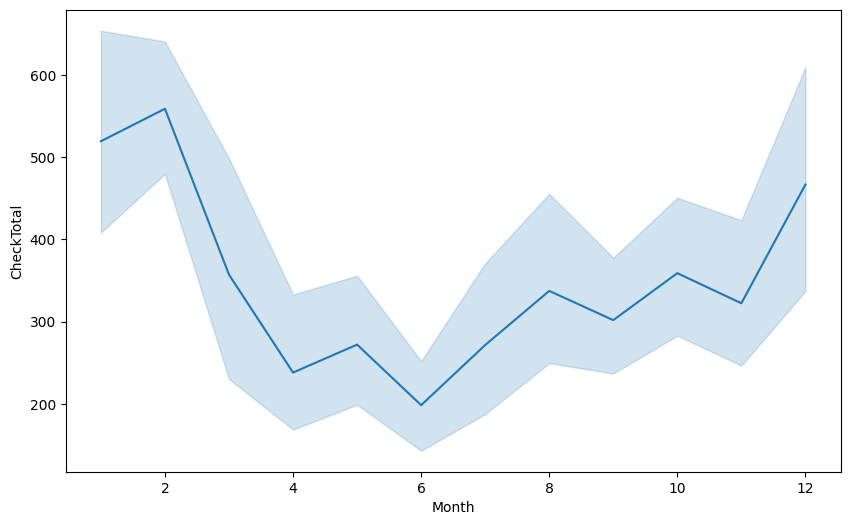

In [ ]:
#Line Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(df_break1,x='Month',y='CheckTotal',)
plt.show()

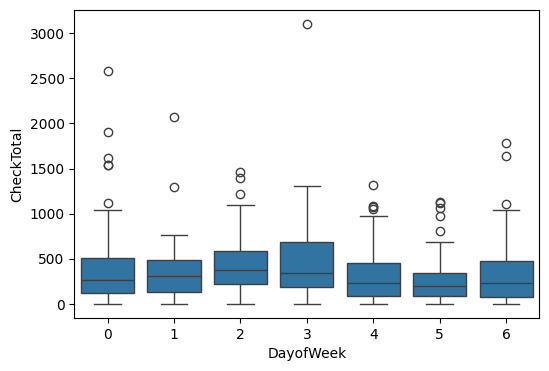

In [ ]:
#Box plot
plt.figure(figsize=(6,4))
sns.boxplot(df_break1,x='DayofWeek',y='CheckTotal')
plt.show()

In [ ]:
#Feature Correlation
df_numeric=df_break1.select_dtypes(include=[np.number])
corr_matrix=df_numeric.corr()


In [ ]:
corr_matrix

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,Lag1,Lag2,Lag3,Lag4
CheckTotal,1.000000,-0.128602,0.241462,-0.105709,-0.057342,-0.108468,0.530596,0.205842,0.184236,0.220618,0.141444
IsHoliday,-0.128602,1.000000,-0.114167,0.021314,0.007112,0.021425,-0.188200,-0.101712,-0.112166,-0.102397,-0.107145
IsPeakSeason,0.241462,-0.114167,1.000000,0.010391,0.011413,-0.308973,0.478709,0.246245,0.256824,0.268597,0.275315
DayofWeek,-0.105709,0.021314,0.010391,1.000000,-0.006546,0.013698,0.000262,-0.055356,0.083973,0.144768,0.027805
DayofMonth,-0.057342,0.007112,0.011413,-0.006546,1.000000,-0.012373,-0.082172,-0.047255,-0.061729,-0.046653,-0.046772
Month,-0.108468,0.021425,-0.308973,0.013698,-0.012373,1.000000,-0.221355,-0.121582,-0.129472,-0.122516,-0.117348
rolling_mean_3,0.530596,-0.188200,0.478709,0.000262,-0.082172,-0.221355,1.000000,0.552406,0.554928,0.576224,0.554860
Lag1,0.205842,-0.101712,0.246245,-0.055356,-0.047255,-0.121582,0.552406,1.000000,0.204184,0.185225,0.220993
Lag2,0.184236,-0.112166,0.256824,0.083973,-0.061729,-0.129472,0.554928,0.204184,1.000000,0.202760,0.184586
Lag3,0.220618,-0.102397,0.268597,0.144768,-0.046653,-0.122516,0.576224,0.185225,0.202760,1.000000,0.202871


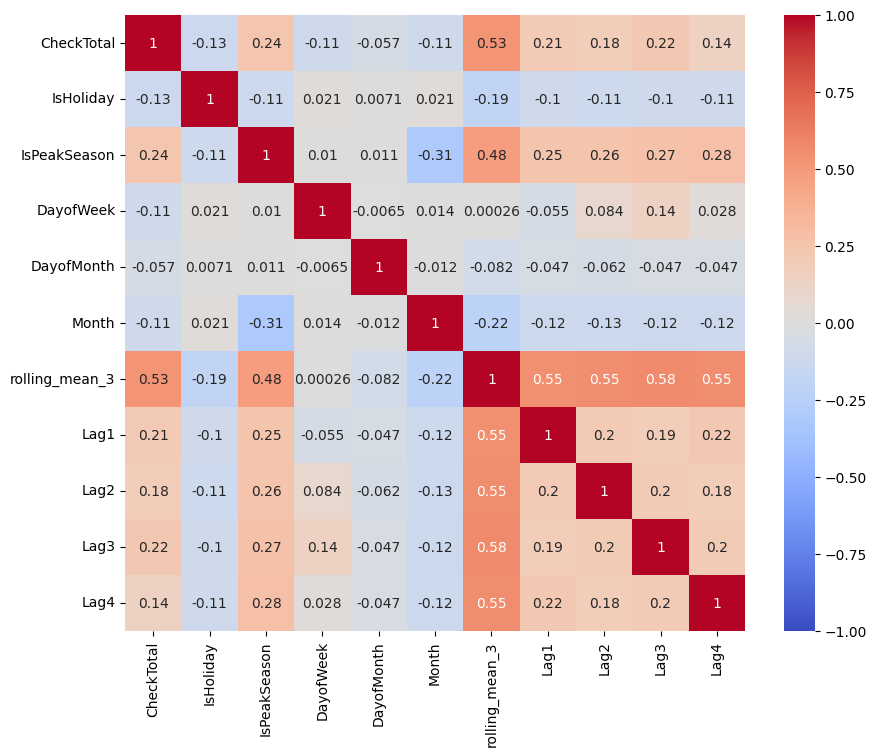

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,vmin=-1,vmax=1,)
plt.show()


#### Model Train

In [ ]:
df_break1.columns

Index(['CheckTotal', 'IsHoliday', 'IsPeakSeason', 'DayofWeek', 'DayofMonth',
       'Month', 'rolling_mean_3', 'is_weekend', 'Lag1', 'Lag2', 'Lag3',
       'Lag4'],
      dtype='object')

In [ ]:
df_break1

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,is_weekend,Lag1,Lag2,Lag3,Lag4
Date,,,,,,,,,,,,
2023-01-07,120.0,0,1,5,7,1,267.214286,True,97.0,704.0,72.0,234.0
2023-01-08,254.0,0,1,6,8,1,298.500000,True,120.0,97.0,704.0,72.0
2023-01-09,218.0,0,1,0,9,1,242.714286,False,254.0,120.0,97.0,704.0
2023-01-10,509.0,0,1,1,10,1,282.000000,False,218.0,254.0,120.0,97.0
2023-01-11,325.0,0,1,2,11,1,318.142857,False,509.0,218.0,254.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,441.0,0,0,4,26,4,398.857143,False,373.0,702.0,91.0,807.0
2024-04-27,487.0,0,0,5,27,4,439.571429,True,441.0,373.0,702.0,91.0
2024-04-28,580.0,0,0,6,28,4,497.285714,True,487.0,441.0,373.0,702.0


In [ ]:
Features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
import numpy as np
X=df_break1[Features]
y=df_break1[Target]

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,shuffle=False)


In [ ]:
X_train.shape,y_test.shape


((432, 11), (48, 1))

In [ ]:
X_train.shape[0]


432

In [ ]:
#Train the Model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg=xgb.XGBRegressor(n_estimator=100,learning_rate=0.05,max_depth=5)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=5)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:365.18178	validation_1-rmse:273.97197
[5]	validation_0-rmse:326.08210	validation_1-rmse:241.89769
[10]	validation_0-rmse:292.65247	validation_1-rmse:220.41234
[15]	validation_0-rmse:266.50434	validation_1-rmse:205.16100
[20]	validation_0-rmse:243.73809	validation_1-rmse:194.41801
[25]	validation_0-rmse:224.40649	validation_1-rmse:188.44487
[30]	validation_0-rmse:209.06151	validation_1-rmse:182.58057
[35]	validation_0-rmse:196.04557	validation_1-rmse:179.36798
[40]	validation_0-rmse:185.03388	validation_1-rmse:178.87365
[45]	validation_0-rmse:176.03158	validation_1-rmse:178.00009
[50]	validation_0-rmse:167.43451	validation_1-rmse:177.61113
[55]	validation_0-rmse:162.03278	validation_1-rmse:176.85761
[60]	validation_0-rmse:157.73248	validation_1-rmse:175.79766
[65]	validation_0-rmse:153.27902	validation_1-rmse:175.55772
[70]	validation_0-rmse:149.45245	validation_1-rmse:174.97340
[75]	validation_0-rmse:143.02684	validation_1-rmse:174.69541
[80]	validation_0-rmse:138

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=100, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['Importance'])

,Importance
DayofWeek,0.051669
DayofMonth,0.122727
Month,0.047814
Lag1,0.108966
Lag2,0.071364
Lag3,0.090647
Lag4,0.077086
rolling_mean_3,0.309206
is_weekend,0.000000
IsHoliday,0.016055


In [ ]:
test=df_break1[X_train.shape[0]:]
test['Prediction']=reg.predict(test[Features])


/tmp/ipython-input-24-37185756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=reg.predict(test[Features])


In [ ]:
df_break1.merge(test[['Prediction']],how='left',left_index=True,right_index=True)

,CheckTotal,IsHoliday,IsPeakSeason,DayofWeek,DayofMonth,Month,rolling_mean_3,is_weekend,Lag1,Lag2,Lag3,Lag4,Prediction
Date,,,,,,,,,,,,,
2023-01-07,120.0,0,1,5,7,1,267.214286,True,97.0,704.0,72.0,234.0,NaN
2023-01-08,254.0,0,1,6,8,1,298.500000,True,120.0,97.0,704.0,72.0,NaN
2023-01-09,218.0,0,1,0,9,1,242.714286,False,254.0,120.0,97.0,704.0,NaN
2023-01-10,509.0,0,1,1,10,1,282.000000,False,218.0,254.0,120.0,97.0,NaN
2023-01-11,325.0,0,1,2,11,1,318.142857,False,509.0,218.0,254.0,120.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,441.0,0,0,4,26,4,398.857143,False,373.0,702.0,91.0,807.0,312.134277
2024-04-27,487.0,0,0,5,27,4,439.571429,True,441.0,373.0,702.0,91.0,545.312805
2024-04-28,580.0,0,0,6,28,4,497.285714,True,487.0,441.0,373.0,702.0,354.420868


## Model Validate and Forecast

#### Model Validate

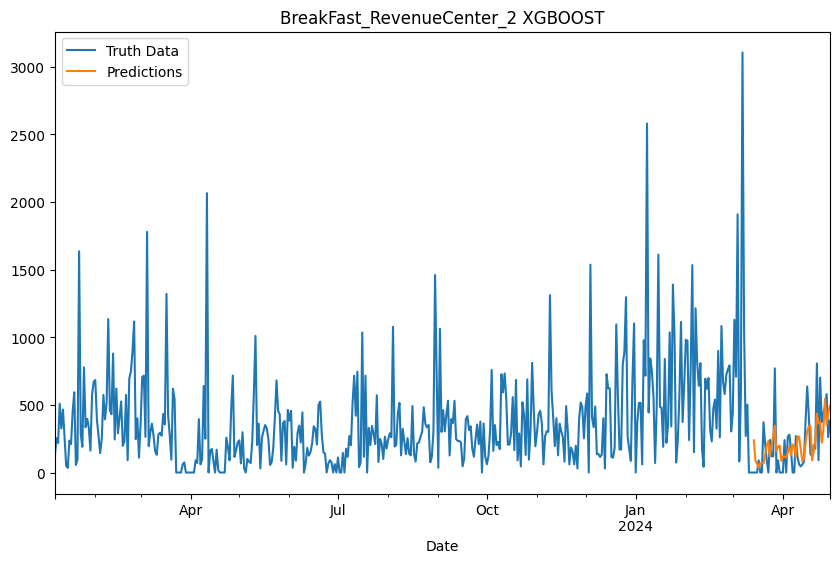

In [ ]:
ax=df_break1[['CheckTotal']].plot(figsize=(10,6))
test['Prediction'].plot(ax=ax,style='-')

name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend(['Truth Data','Predictions'])
plt.show()

In [ ]:
type(X_test),type(y_test),X_test.shape,y_test.shape

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame, (48, 11), (48, 1))

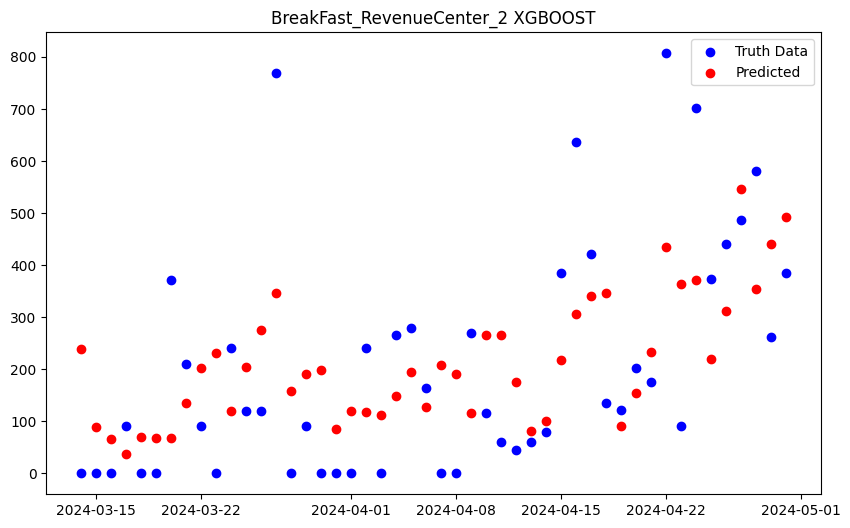

In [ ]:
plt.figure(num=2,figsize=(10,6))
plt.scatter(test.index,test['CheckTotal'],label='Truth Data',c='b')
plt.scatter(test.index,test['Prediction'],label='Predicted',c='r')
name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend()
plt.show()

In [ ]:
# Create future dates for 90 days
test_dates = X_test.index
test_dates
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Initialize future dataframe
test_fc = pd.DataFrame(index=test_dates)
test_fc['DayofWeek'] = test_fc.index.dayofweek
test_fc['DayofMonth'] = test_fc.index.day
test_fc['Month'] = test_fc.index.month
test_fc['is_weekend'] = test_fc.index.dayofweek >= 5
test_fc['IsHoliday'] = test_fc.index.map(lambda x: 1 if x in uae_holidays else 0)
test_fc['IsPeakSeason'] = test_fc.index.month.isin([11, 12, 1, 2, 3]).astype(int)

# Initialize lag and rolling features
future_test_predictions = []
last_4_days = df['CheckTotal'].tail(4).tolist()  # For Lag1 to Lag4
last_3_days = df['CheckTotal'].tail(3).tolist()  # For rolling_mean_3

In [ ]:
features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']
# Iteratively predict each day
for i in range(X_test.shape[0]):
    current_features = test_fc.iloc[i:i+1][['DayofWeek', 'DayofMonth', 'Month',
                                             'is_weekend', 'IsHoliday', 'IsPeakSeason']].copy()
    current_features['Lag1'] = last_4_days[-1] if i == 0 else future_test_predictions[-1]
    current_features['Lag2'] = last_4_days[-2] if i <= 1 else future_test_predictions[-2]
    current_features['Lag3'] = last_4_days[-3] if i <= 2 else future_test_predictions[-3]
    current_features['Lag4'] = last_4_days[-4] if i <= 3 else future_test_predictions[-4]
    rolling_data_3 = last_3_days[-3:] if i == 0 else (last_3_days[-3+i:] + future_test_predictions[:i])[-3:]

    current_features['rolling_mean_3'] = pd.Series(rolling_data_3).mean()


    # Predict revenue
    pred = reg.predict(current_features[features])[0]
    future_test_predictions.append(pred)

    # Update lag and rolling data
    if i < 4:
        last_4_days.append(pred)
    else:
        last_4_days = last_4_days[1:] + [pred]
    if i < 3:
        last_3_days.append(pred)
    else:
        last_3_days = last_3_days[1:] + [pred]

# Create forecast
forecast_test_df = pd.DataFrame({'Date': test_dates, 'Predicted_CheckTotal': future_test_predictions})
print(forecast_test_df.head())

        Date  Predicted_CheckTotal
0 2024-03-14            341.740173
1 2024-03-15            288.109833
2 2024-03-16            202.189865
3 2024-03-17            200.727341
4 2024-03-18            225.298676


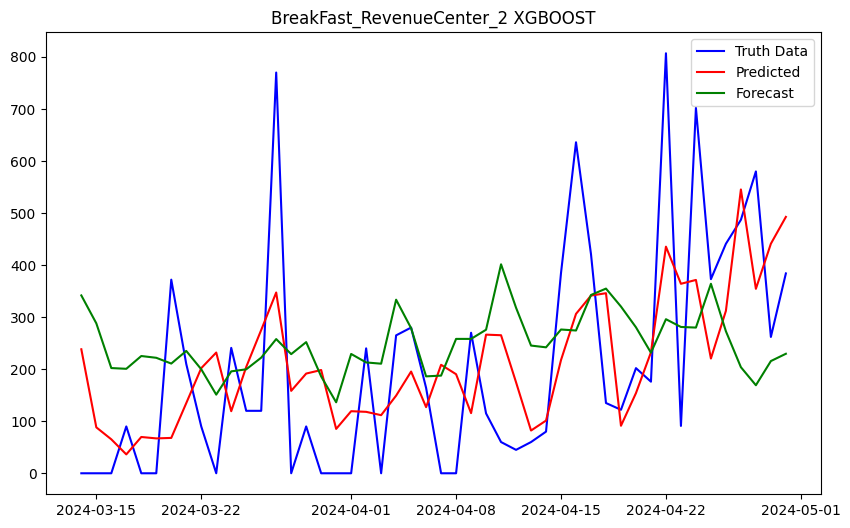

In [ ]:
plt.figure(num=3,figsize=(10,6))
plt.plot(test.index,test['CheckTotal'],label='Truth Data',c='b')
plt.plot(test.index,test['Prediction'],label='Predicted',c='r')
plt.plot(forecast_test_df['Date'],forecast_test_df['Predicted_CheckTotal'],label='Forecast',c='g')
name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} XGBOOST'
plt.title(name)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 174.16690652395764
MAE: 147.02597045898438
R²: 0.3657810091972351


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 174.16690652395764
MAE: 147.02597045898438
R²: 0.3657810091972351


#### Forecast

In [ ]:
# Create future dates for 90 days
last_date = df_break1.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Initialize future dataframe
future_df = pd.DataFrame(index=future_dates)
future_df['DayofWeek'] = future_df.index.dayofweek
future_df['DayofMonth'] = future_df.index.day
future_df['Month'] = future_df.index.month
future_df['is_weekend'] = future_df.index.dayofweek >= 5
future_df['IsHoliday'] = future_df.index.map(lambda x: 1 if x in uae_holidays else 0)
future_df['IsPeakSeason'] = future_df.index.month.isin([11, 12, 1, 2, 3]).astype(int)

# Initialize lag and rolling features
future_predictions = []
last_4_days = df['CheckTotal'].tail(4).tolist()  # For Lag1 to Lag4
last_3_days = df['CheckTotal'].tail(3).tolist()  # For rolling_mean_3


features=['DayofWeek',
       'DayofMonth', 'Month','Lag1', 'Lag2','Lag3', 'Lag4','rolling_mean_3', 'is_weekend','IsHoliday', 'IsPeakSeason']
Target=['CheckTotal']
# Iteratively predict each day
for i in range(90):
    current_features = future_df.iloc[i:i+1][['DayofWeek', 'DayofMonth', 'Month',
                                             'is_weekend', 'IsHoliday', 'IsPeakSeason']].copy()
    current_features['Lag1'] = last_4_days[-1] if i == 0 else future_predictions[-1]
    current_features['Lag2'] = last_4_days[-2] if i <= 1 else future_predictions[-2]
    current_features['Lag3'] = last_4_days[-3] if i <= 2 else future_predictions[-3]
    current_features['Lag4'] = last_4_days[-4] if i <= 3 else future_predictions[-4]
    rolling_data_3 = last_3_days[-3:] if i == 0 else (last_3_days[-3+i:] + future_predictions[:i])[-3:]

    current_features['rolling_mean_3'] = pd.Series(rolling_data_3).mean()


    # Predict revenue
    pred = reg.predict(current_features[features])[0]
    future_predictions.append(pred)

    # Update lag and rolling data
    if i < 4:
        last_4_days.append(pred)
    else:
        last_4_days = last_4_days[1:] + [pred]
    if i < 3:
        last_3_days.append(pred)
    else:
        last_3_days = last_3_days[1:] + [pred]

# Create and save forecast
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_CheckTotal': future_predictions})
#forecast_df.to_csv('dubai_breakfast_forecast_3months.csv', index=False)
#print("3-month forecast saved to 'dubai_breakfast_forecast_3months.csv'")
print(forecast_df.head())

        Date  Predicted_CheckTotal
0 2024-05-01            461.689697
1 2024-05-02            456.540802
2 2024-05-03            376.933228
3 2024-05-04            367.934113
4 2024-05-05            191.226913


In [ ]:
future_dates

DatetimeIndex(['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04',
               '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08',
               '2024-05-09', '2024-05-10', '2024-05-11', '2024-05-12',
               '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16',
               '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20',
               '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
               '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28',
               '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01',
               '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05',
               '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09',
               '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13',
               '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
               '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
               '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
      

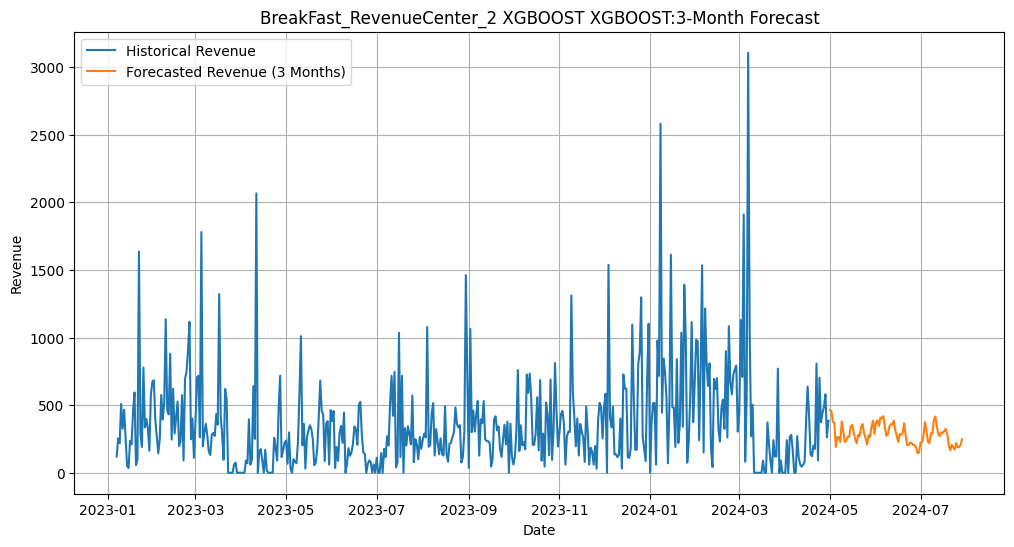

In [ ]:
import matplotlib.pyplot as plt

# Plot historical and forecasted revenue
plt.figure(figsize=(12, 6))
plt.plot(df_break1.index, df_break1['CheckTotal'], label='Historical Revenue', color='#1f77b4')
plt.plot(forecast_df['Date'], forecast_df['Predicted_CheckTotal'], label='Forecasted Revenue (3 Months)', color='#ff7f0e')
name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} XGBOOST'
plt.title(f'{name} XGBOOST:3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

Save the forecast results

In [ ]:
future_da=pd.DataFrame({'Date':forecast_df['Date'], 'Predicted_CheckTotal':forecast_df['Predicted_CheckTotal']})


In [ ]:
file_name=f'{df["MealPeriod"][0]}_{df["RevenueCentreName"][0]} XGBOOST'
future_da.to_csv(f"/content/drive/MyDrive/Datasets/hotel/XGBOOST Forecast/{file_name}.csv",index=False)